In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

import json
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

import cv2
import pickle

In [2]:
dataset_path = '/dtu/datasets1/02514/data_wastedetection'
anns_file_path = dataset_path + '/' + 'annotations.json'

coco = COCO(anns_file_path)

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1
        
super_cat_names.append("Nothing")
super_cat_ids["Nothing"] = nr_super_cats
        

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [4]:
ssResult = pickle.load( open( "ssResult.pickle", "rb" ) )


In [5]:
def IOU(rect1, rect2):
    boxA = [rect1[0], rect1[1], rect1[0]+rect1[2], rect1[1]+rect1[3]]
    boxB = [rect2[0], rect2[1], rect2[0]+rect2[2], rect2[1]+rect2[3]]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [6]:
def getCat(rect, anns):
    best_cat = -1
    best_iou = 0
    for ann in anns:
        iou = IOU(ann['bbox'], rect)
        if iou < best_iou:
            continue
        best_cat = ann['category_id']
        best_iou = iou
    if best_iou < 0.3:
        return -1
    if best_iou > 0.5:
        return best_cat
    return -2

In [7]:
class TACO(torch.utils.data.Dataset):
    def __init__(self, set_type, transform, data_path='dataset_path'):
        'Initialization'
        self.transform = transform
        data_path = dataset_path
        self.image_paths = []
        self.image_bbox = []
        self.image_cat = []
        self.image_ids = []
        self.image_base = None
        self.image_loaded = ""
        self.n_background = 0
        for i in tqdm(range(len(imgs))):
            #if i > 10:
            #    return
            img = imgs[i]
            #batch_nr = int(os.path.split(img['file_name'])[0][6:])
            file_name = os.path.split(img['file_name'])[1]
            if file_name[0] == 'I':
                img_nr = int(file_name[6:8])
            else:
                img_nr = int(file_name[0:6])
            if set_type == "train":
                if not img_nr < 75:
                    continue
            elif set_type == "val":
                if not 75 <= img_nr < 95:
                    continue
            elif set_type == "test":
                if not 95 <= img_nr:
                    continue
            
            
            annIds = coco.getAnnIds(imgIds=img['id'], catIds=[], iscrowd=None)
            anns_sel = coco.loadAnns(annIds)
            rects = ssResult[img['id']]
            
            back_rects = []
            n_true = 0

            for rect in rects:
                cat = getCat(rect, anns_sel)
                if cat == -2:
                    continue
                if cat == -1:
                    back_rects.append(rect)
                    continue
                self.image_paths.append(dataset_path + "/" + img['file_name'])
                self.image_bbox.append(rect)
                self.image_cat.append(cat)
                self.image_ids.append(img['id'])
                n_true += 1
                
            backrate = 3*n_true/len(back_rects)
            for rect in back_rects:
                if np.random.rand() > backrate:
                    continue
                self.image_paths.append(dataset_path + "/" + img['file_name'])
                self.image_bbox.append(rect)
                self.image_cat.append(-1)
                self.image_ids.append(img['id'])
                self.n_background += 1
                
            for ann in anns_sel:
                self.image_paths.append(dataset_path + "/" + img['file_name'])
                self.image_bbox.append(ann['bbox'])
                self.image_cat.append(ann['category_id'])
                self.image_ids.append(img['id'])
        print(self.n_background)
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        if image_path != self.image_loaded:
            self.image_base = Image.open(image_path)
            self.image_loaded = image_path
        
        [x, y, w, h] = self.image_bbox[idx]
        image = self.image_base.crop((x,y,x+w,y+h))
        
        if self.image_cat[idx] != -1:
            y = super_cat_ids[categories[self.image_cat[idx]]['supercategory']]
        else:
            y = nr_super_cats
        X = self.transform(image)
        return X, y

In [8]:
size = 224
the_transform = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

batch_size = 64
trainset = TACO("train", transform=the_transform)
print(len(trainset))
valset = TACO("val", transform=the_transform)
print(len(valset))
testset = TACO("test", transform=the_transform)
print(len(testset))

  0%|          | 0/1500 [00:00<?, ?it/s]

88908
122263


  0%|          | 0/1500 [00:00<?, ?it/s]

22009
30159


  0%|          | 0/1500 [00:00<?, ?it/s]

13273
18153


In [9]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=3)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

6.405946731567383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


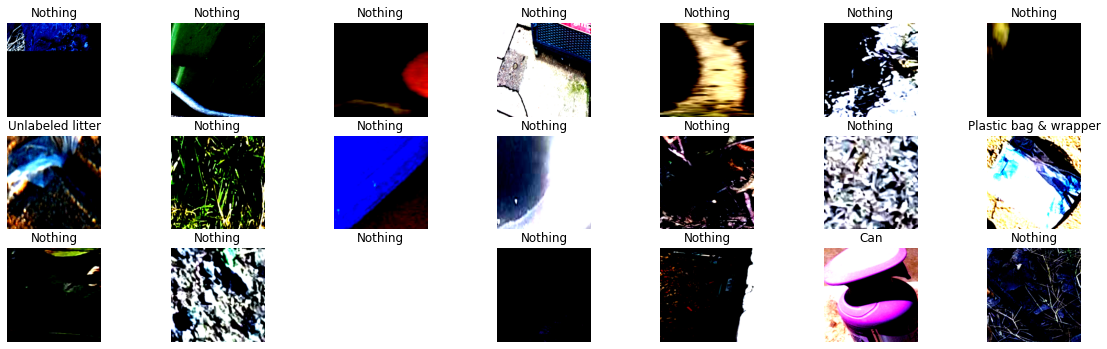

In [10]:
import time
t = time.time()
images, labels = next(iter(train_loader))
print(time.time() - t)
print
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(super_cat_names[labels[i]])
    plt.axis('off')


In [21]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        loss = F.binary_cross_entropy
        return loss(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    patience = 0
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):        
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            one_hot = F.one_hot(target,nr_super_cats+1).float()
            loss = loss_fun(output, one_hot[:,:nr_super_cats])
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            one_hot = F.one_hot(target,nr_super_cats+1).float()
            test_loss.append(loss_fun(output, one_hot[:,:nr_super_cats]).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(valset))
        out_dict['test_acc'].append(test_correct/len(valset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
        
             
        
        if out_dict['test_loss'][-1] > min(out_dict['test_loss']):
            patience += 1 
        else: 
            patience = 0
            
        if patience == 7:
            print("EARLY STOPPED!")
            break 
       
    return out_dict

In [22]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
                nn.Linear(num_ftrs, nr_super_cats),
                nn.Sigmoid()
        )
model.to(device)

lr = 0.00001
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [23]:
num_epoch = 10
out_dict = train(model, optimizer, num_epoch)
torch.save(model.state_dict(), "model_noback.pt")
pickle.dump(out_dict, open( "out_dict.pickle", "wb" ))

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/1911 [00:00<?, ?it/s]

Loss train: 0.133	 test: 0.039	 Accuracy train: 42.8%	 test: 13.3%


  0%|          | 0/1911 [00:00<?, ?it/s]

Loss train: 0.025	 test: 0.030	 Accuracy train: 81.7%	 test: 14.5%


  0%|          | 0/1911 [00:00<?, ?it/s]

Loss train: 0.014	 test: 0.030	 Accuracy train: 96.4%	 test: 14.7%


  0%|          | 0/1911 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.031	 Accuracy train: 102.9%	 test: 15.0%


  0%|          | 0/1911 [00:00<?, ?it/s]

Loss train: 0.006	 test: 0.033	 Accuracy train: 105.7%	 test: 14.7%


  0%|          | 0/1911 [00:00<?, ?it/s]

Loss train: 0.004	 test: 0.035	 Accuracy train: 107.2%	 test: 14.3%


  0%|          | 0/1911 [00:00<?, ?it/s]

Loss train: 0.003	 test: 0.037	 Accuracy train: 108.2%	 test: 14.3%


  0%|          | 0/1911 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0, 0.5, 'Loss')

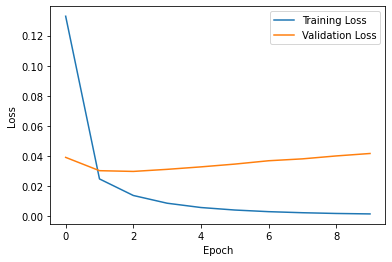

In [41]:
plt.plot(out_dict['train_loss'])
plt.plot(out_dict['test_loss'])
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [20]:
#torch.save(model.state_dict(), "model_third.pt")


In [26]:
model_l = models.resnet18(pretrained=True)
num_ftrs = model_l.fc.in_features
model_l.fc = nn.Sequential(
                nn.Linear(num_ftrs, nr_super_cats),
                nn.Sigmoid()
        )
model_l.load_state_dict(torch.load("model_noback.pt"))
model_l.to(device)
model_l.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

  0%|          | 0/1500 [00:00<?, ?it/s]

Number of total detections: 32
Number of sorted detections: 5


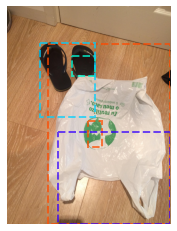

Number of total detections: 4
Number of sorted detections: 4


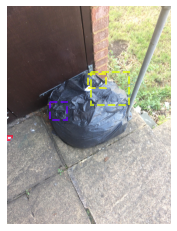

Number of total detections: 38
Number of sorted detections: 20


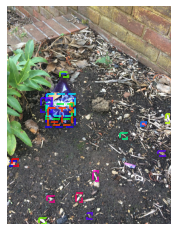

Number of total detections: 22
Number of sorted detections: 10


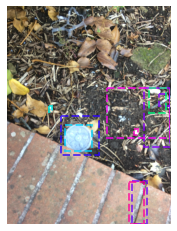

Number of total detections: 21
Number of sorted detections: 9


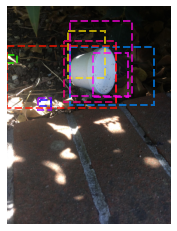

In [39]:
class out_obj():
    def __init__(self, rect, clas, score):
        self.rect = rect
        self.clas = clas
        self.score = score
        self.removed = False
        self.matched = False
        
all_outs_class = []
total_gt_class = np.zeros(nr_super_cats)
for i in tqdm(range(len(imgs))):
    img = imgs[i]
    batch_nr = int(os.path.split(img['file_name'])[0][6:])
    file_name = os.path.split(img['file_name'])[1]
    if file_name[0] == 'I':
        img_nr = int(file_name[6:8])
    else:
        img_nr = int(file_name[0:6])
    if not 95 <= img_nr:
        continue

    annIds = coco.getAnnIds(imgIds=img['id'], catIds=[], iscrowd=None)
    anns_sel = coco.loadAnns(annIds)
    rects = ssResult[img['id']]

    im_path = dataset_path + "/" + img['file_name']
    image = Image.open(im_path)
    
    outs = []
    for rect in rects:
        [x, y, w, h] = rect
        box = image.crop((x,y,x+w,y+h))
        box = the_transform(box)
        box = torch.unsqueeze(box, 0)
        box = box.to(device)
        output = model_l(box)
        for class_id in range(nr_super_cats):
            score = output[0][class_id]
            if score > 0.5:
                outs.append(out_obj(rect, class_id, score.cpu().item()))
        
    final_outs = []
    for class_id in range(nr_super_cats):
        class_outs = []
        for out in outs:
            if out.clas == class_id:
                class_outs.append(out)
                
        class_outs = sorted(class_outs, key=lambda x: x.score, reverse=True)
        for j in range(len(class_outs)):
            if class_outs[j].removed:
                continue
            for k in range(j+1, len(class_outs)):
                if class_outs[k].removed:
                    continue
                iou = IOU(class_outs[j].rect, class_outs[k].rect)
                if iou > 0.5:
                    class_outs[k].removed = True
        for out in class_outs:
            if not out.removed:
                final_outs.append(out)
    

    
    final_outs = sorted(final_outs, key=lambda x: x.score, reverse=True)
    GT_used = np.full(len(anns_sel), False)
    TP = 0
    precision = [1]
    recall = [0]
    for j in range(len(final_outs)):
        for k, ann in enumerate(anns_sel):
            if GT_used[k]:
                continue
            sup_cat = super_cat_ids[categories[ann['category_id']]['supercategory']]
            if final_outs[j].clas != sup_cat:
                continue
            iou = IOU(ann['bbox'], final_outs[j].rect)
            if iou < 0.5:
                continue
            final_outs[j].matched = True
            GT_used[k] = True
            TP += 1
            break
        all_outs_class.append(final_outs[j])
        precision.append(TP / (j+1))
        recall.append(TP / len(GT_used))
    precision.append(0)
    recall.append(1)
    AP = np.trapz(precision, recall)
    #print("Average Precision: " + str(AP))
    
    for j in range(len(anns_sel)):
        total_gt_class[super_cat_ids[categories[anns_sel[j]['category_id']]['supercategory']]] += 1
    
    if i < 80:
        print("Number of total detections: " + str(len(outs)))
        print("Number of sorted detections: " + str(len(final_outs)))
        # Show image
        fig,ax = plt.subplots(1)
        plt.axis('off')
        plt.imshow(image)

        # Show annotations
        for out in final_outs:
            color = colorsys.hsv_to_rgb(np.random.random(),1,1)
            [x, y, w, h] = out.rect
            rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                             facecolor='none', alpha=0.7, linestyle = '--')
            ax.add_patch(rect)
            #print(super_cat_names[out.clas])

        plt.show()
    

Mean Average Precision: 0.13510790795429867


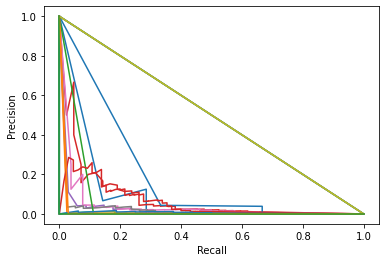

In [40]:
all_outs_class = sorted(all_outs_class, key=lambda x: x.score, reverse=True)
APs = []
for i in range(nr_super_cats):
    TP = 0
    precision = [1]
    recall = [0]
    total_GT = total_gt_class[i]
    if total_GT == 0:
        continue
    for j in range(len(all_outs_class)):
        if all_outs_class[j].clas != i:
            continue
        if all_outs_class[j].matched:
            TP += 1
        precision.append(TP / (j+1))
        recall.append(TP / total_GT)
    precision.append(0)
    recall.append(1)
    AP = np.trapz(precision, recall)
    APs.append(AP)
    #print("Average Precision of Class " + super_cat_names[i] + ": " + str(AP))
    plt.plot(recall,precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.savefig("plot.png")
print("Mean Average Precision: " + str(np.mean(APs)))

NameError: name 'all_outs_class' is not defined